In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np

In [53]:
def parse_log(fname):
    with open(fname) as f:
        lines = f.readlines()

    messages = []
    for line in lines:
        try:
            messages.append(json.loads(line.strip()))
        except json.JSONDecodeError:
            pass
    return messages


def plot_wait_time(fname, max=0.05):
    messages = parse_log(fname)

    train_times = []
    end = None
    for m in messages:
        if m["event"] == "training end":
            end = m["time"]
        if m["event"] == "training start" and end is not None:
            train_times.append(m["time"] - end)

    print(train_times[:10])

    return plt.hist(train_times, bins=np.linspace(0, max, 100), color="#6D0EDB")[-1]


def plot_log(fname, title=""):
    messages = parse_log(fname)
    # print(messages)
    origin = messages[0]["time"]
    assert messages[0]["event"] == "run start"

    fig, ax = plt.subplots()

    rows = {"setup": 3, "get-batch": 2, "train": 1, "epoch": 0}

    ax.set_yticks(list(rows.values()), labels=list(rows))
    ax.set_title(title)

    data = {"batches": []}

    for m in messages:
        t = m["time"] - origin

        if m["event"] == "run start":
            text_str = "\n".join([f"{k}: {v}" for k, v in m["locals"].items() if v is not None])
            props = dict(boxstyle="round", facecolor="#F5F5F5", alpha=0.5)
            ax.text(
                1.05,
                0.95,
                text_str,
                transform=ax.transAxes,
                fontsize=14,
                verticalalignment="top",
                bbox=props,
            )

        if m["event"] == "setup end":
            ax.barh(
                rows["setup"],
                m["duration"],
                left=t - m["duration"],
                edgecolor="k",
                linewidth=0.1,
                color="#6D0EDB",
                zorder=1,
            )

        if m["event"] == "get-batch end":
            ax.barh(
                rows["get-batch"],
                m["duration"],
                left=t - m["duration"],
                alpha=0.3,
                color="#C396F9",
                zorder=1,
            )
            data["batches"].append(m["duration"])

        if m["event"] == "training end":
            ax.barh(
                rows["train"],
                m["duration"],
                left=t - m["duration"],
                color="#FF6554",
                zorder=1,  # edgecolor="k", linewidth=0.1,
            )

        if m["event"] == "epoch end":
            ax.barh(
                rows["epoch"],
                m["duration"],
                left=t - m["duration"],
                edgecolor="k",
                linewidth=0.1,
                color="#FF9E0D",
                zorder=1,
            )

    plt.grid(axis="x", zorder=0, alpha=0.5)

    print("average batch duration", np.mean(data["batches"]))

[2.747396945953369, 1.4147791862487793, 1.786661148071289, 2.158733606338501, 2.1153035163879395, 1.9628901481628418, 2.3618502616882324, 1.9002833366394043, 1.905867338180542, 1.8065755367279053]


Text(0.5, 0, 'time (sec)')

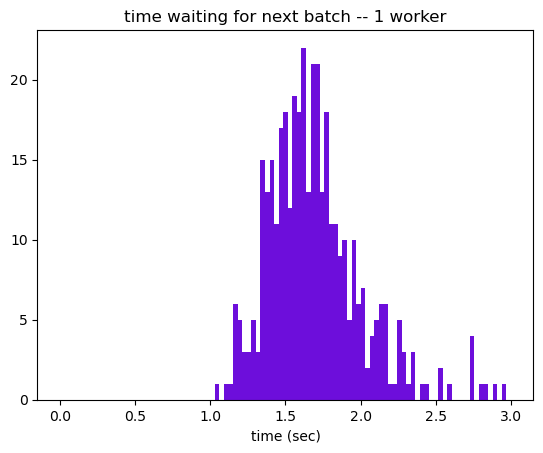

In [54]:
plot_wait_time("logs/simple.txt", max=3)
plt.title("time waiting for next batch -- 1 worker")
plt.xlabel("time (sec)")

[0.0004928112030029297, 0.00048470497131347656, 0.0013124942779541016, 0.0005276203155517578, 0.00046443939208984375, 0.002017974853515625, 0.0003952980041503906, 0.0004687309265136719, 0.0004496574401855469, 0.019271373748779297]


Text(0.5, 0, 'time (sec)')

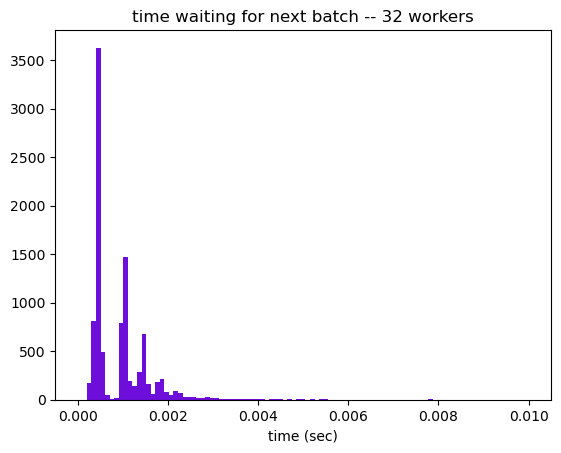

In [55]:
plot_wait_time("logs/best-case-b.txt", max=0.01)
plt.title("time waiting for next batch -- 32 workers")
plt.xlabel("time (sec)")

[0.26466989517211914, 0.0004792213439941406, 0.5069580078125, 0.00046539306640625, 0.0005269050598144531, 0.0005044937133789062, 0.0005636215209960938, 0.0005285739898681641, 0.0005488395690917969, 0.0004773139953613281]


Text(0.5, 0, 'time (sec)')

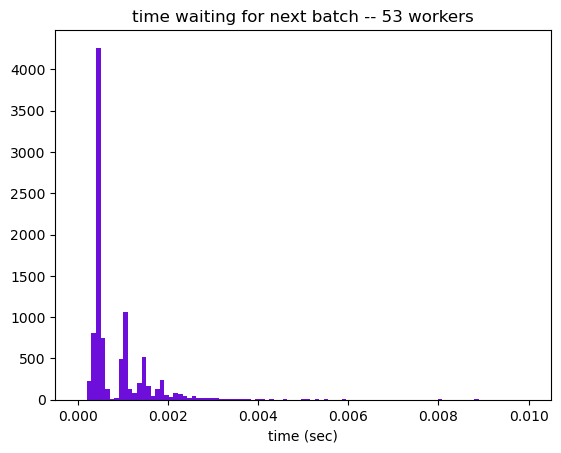

In [56]:
plot_wait_time("logs/best-case-c.txt", max=0.01)
plt.title("time waiting for next batch -- 53 workers")
plt.xlabel("time (sec)")

average batch duration 0.23771566034467081


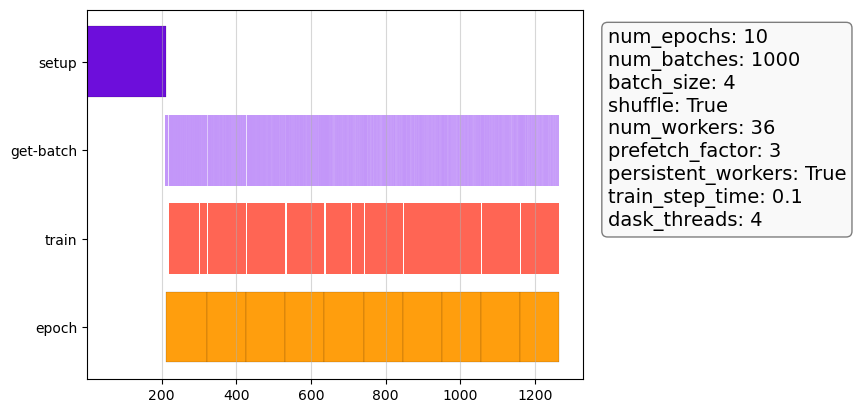

In [51]:
plot_log("logs/best-case-b.txt")

average batch duration 0.3251258844755702


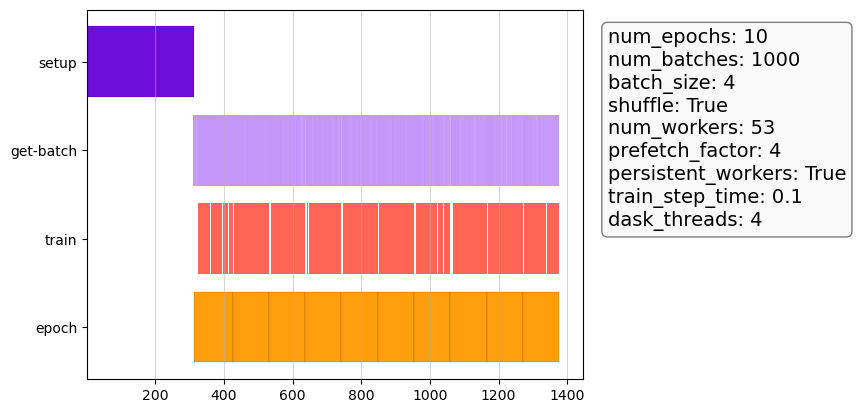

In [52]:
plot_log("logs/best-case-c.txt")

average batch duration 0.12706178076126995


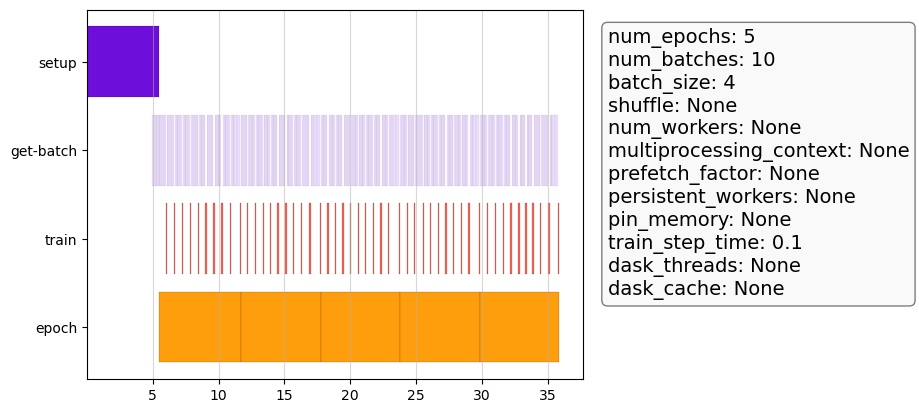

In [87]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 > logs/simple.txt
plot_log("logs/simple.txt")

average batch duration 0.15395500302314757


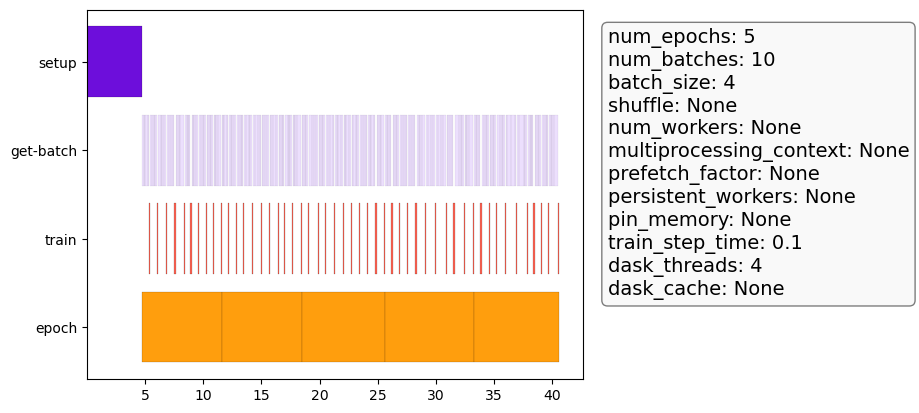

In [64]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --dask-threads 4 > logs/simple_dask_4_threads.txt
plot_log("logs/simple_dask_4_threads.txt")

average batch duration 0.03648731231689453


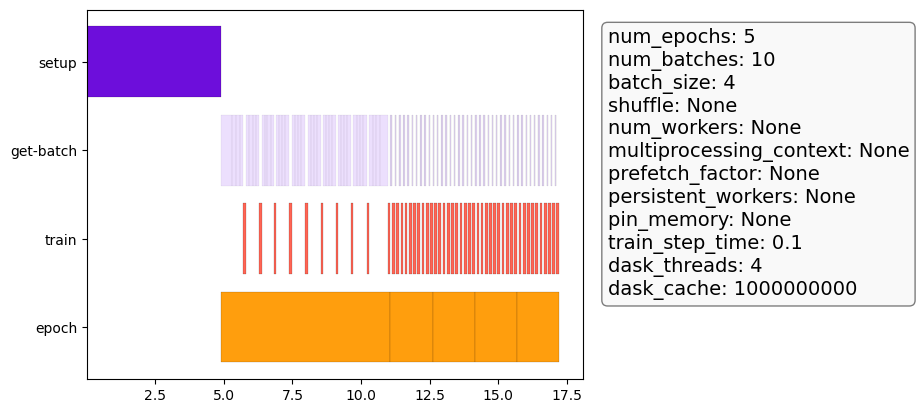

In [68]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --dask-threads 4 --dask-cache 1000000000 > logs/simple_dask_4_threads_cache.txt
plot_log("logs/simple_dask_4_threads_cache.txt")

average batch duration 0.3216062996017968


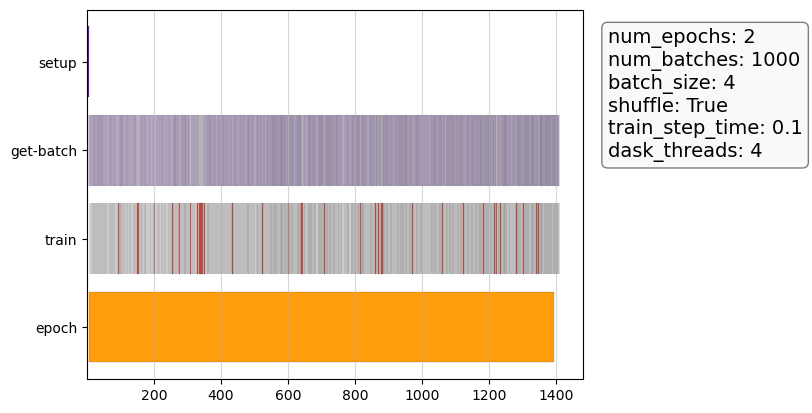

In [96]:
# !python main.py --batch-size 4 --num-epochs 2 --num-batches 1000 --dask-threads 4 --shuffle > logs/simple_dask_4_threads_cache_custom.txt
plot_log("logs/simple_dask_4_threads_cache_custom.txt")

average batch duration 0.34188266515731813


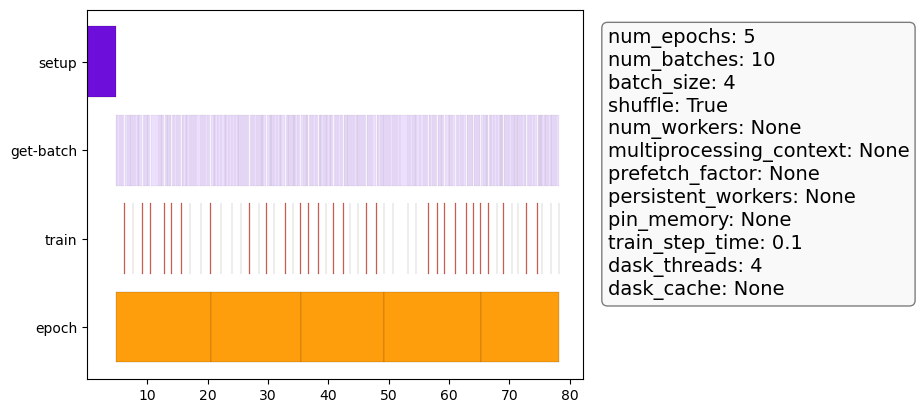

In [74]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --dask-threads 4 --shuffle > logs/simple_dask_4_threads_shuffle.txt
plot_log("logs/simple_dask_4_threads_shuffle.txt")

average batch duration 0.3091552509475


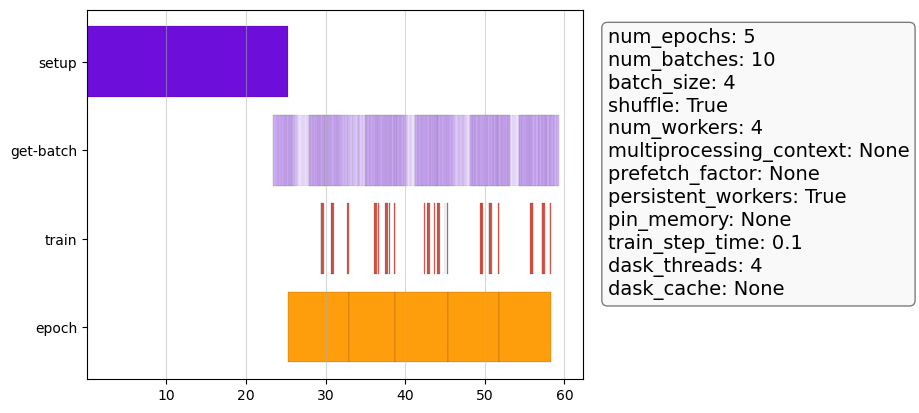

In [86]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --dask-threads 4 --shuffle --num-workers 4 --persistent-workers > logs/with_4_workers_dask_4_threads_shuffle.txt
plot_log("logs/with_4_workers_dask_4_threads_shuffle.txt")

average batch duration 0.296526997089386


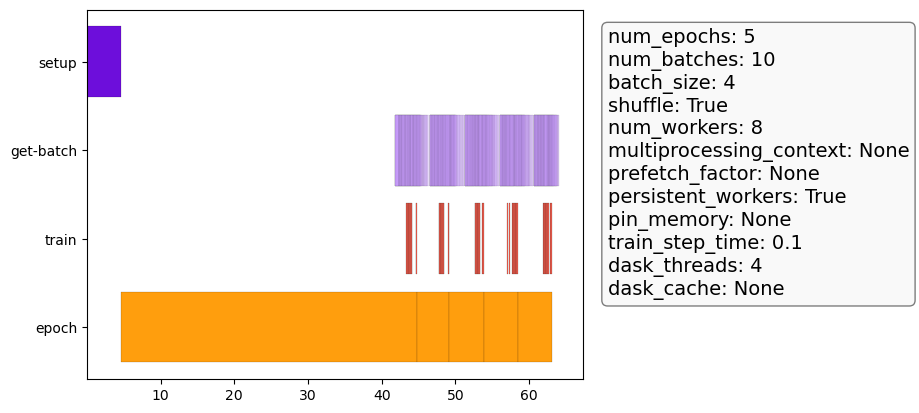

In [77]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --dask-threads 4 --shuffle --num-workers 8 --persistent-workers > logs/with_8_workers_dask_4_threads_shuffle.txt
plot_log("logs/with_8_workers_dask_4_threads_shuffle.txt")

average batch duration 0.30231852643191814


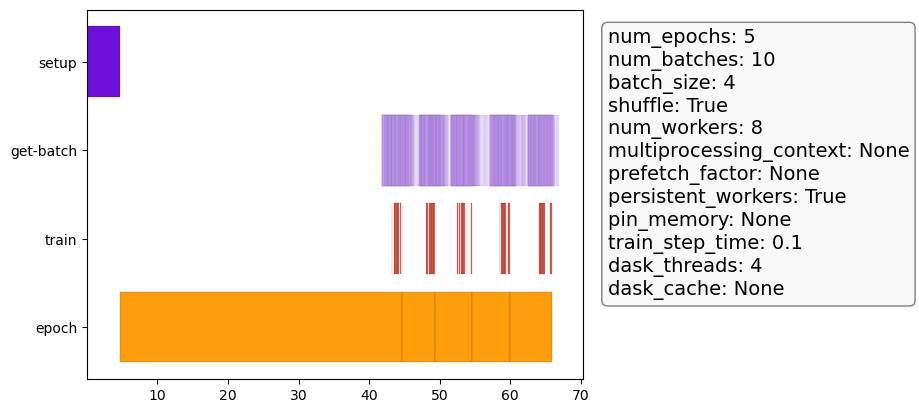

In [78]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --dask-threads 4 --shuffle --num-workers 8 --persistent-workers > logs/with_12_workers_dask_4_threads_shuffle.txt
plot_log("logs/with_12_workers_dask_4_threads_shuffle.txt")

average batch duration 0.15608541802926498


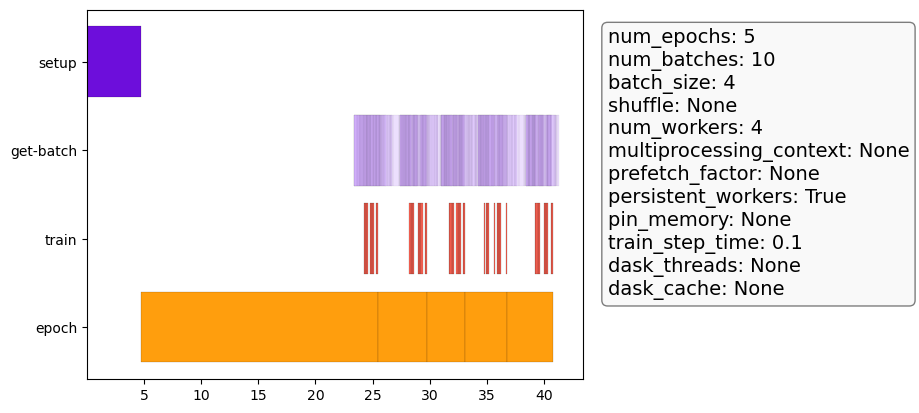

In [71]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 4 --persistent-workers > logs/with_4_workers.txt
plot_log("logs/with_4_workers.txt")

average batch duration 0.13043402406302365


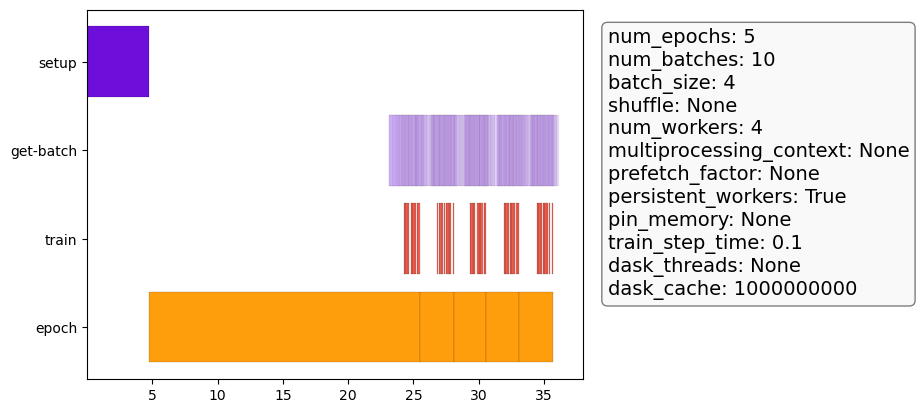

In [72]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 4 --persistent-workers --dask-cache 1000000000 > logs/with_4_workers_dask_cache.txt
plot_log("logs/with_4_workers_dask_cache.txt")

average batch duration 0.0389128049214681


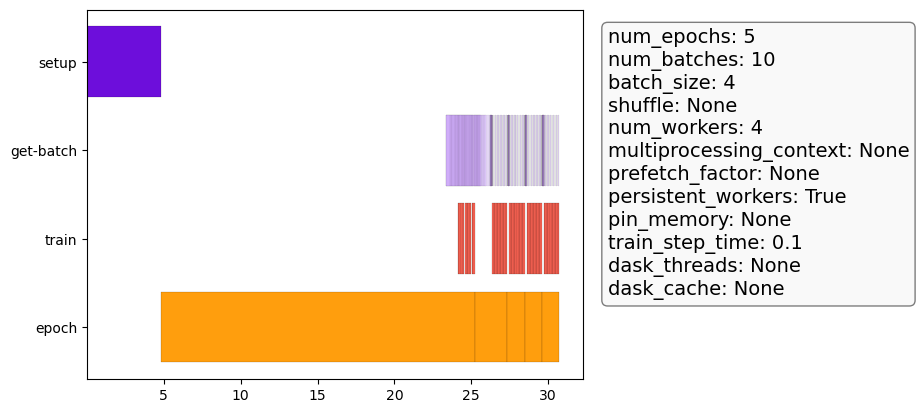

In [73]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 4 --persistent-workers > logs/with_4_workers_dask_global_cache.txt
plot_log("logs/with_4_workers_dask_global_cache.txt")

In [ ]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 4 --persistent-workers > logs/with_4_workers_dask_global_cache.txt
plot_log("logs/with_4_workers_dask_global_cache.txt")

average batch duration 0.14103929386582487


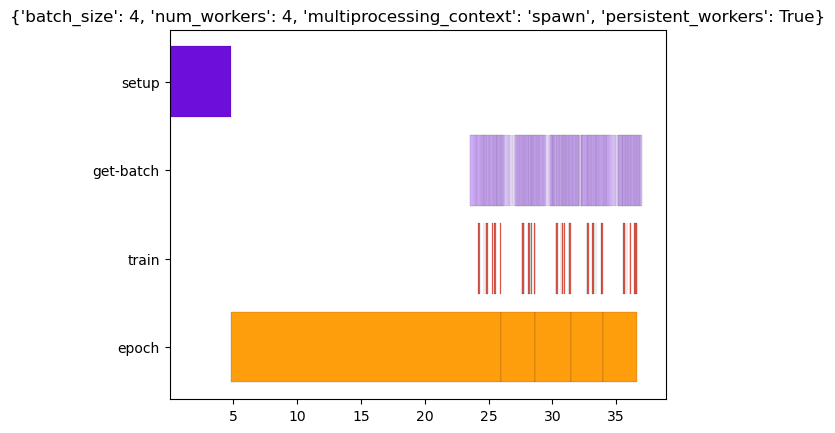

In [44]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 4 --persistent-workers --multiprocessing-context spawn > logs/with_4_workers_spawn.txt
plot_log("logs/with_4_workers_spawn.txt")

average batch duration 0.18074141631181212


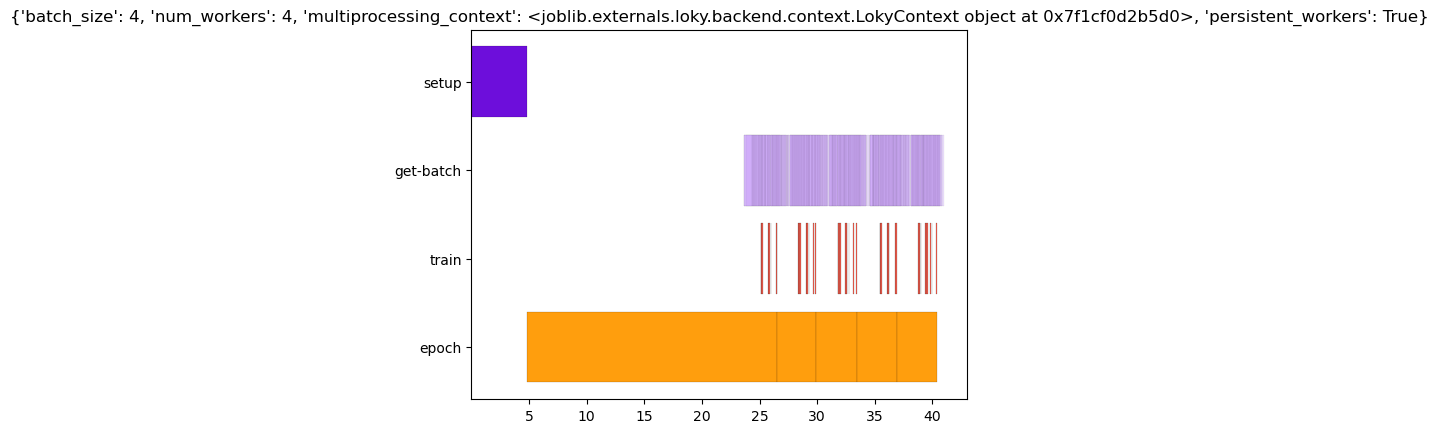

In [49]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 4 --persistent-workers --multiprocessing-context loky > logs/with_4_workers_loky.txt
plot_log("logs/with_4_workers_loky.txt")

average batch duration 0.14077582955360413


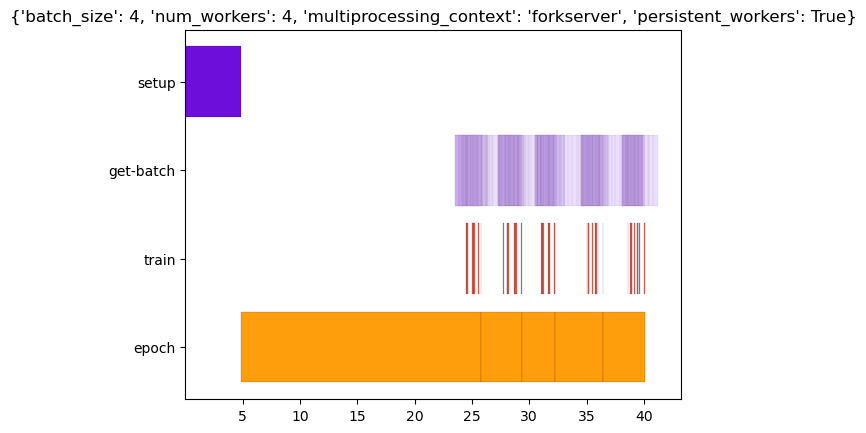

In [45]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 4 --persistent-workers --multiprocessing-context forkserver > logs/with_4_workers_forkserver.txt
plot_log("logs/with_4_workers_forkserver.txt")

average batch duration 0.14091673493385315


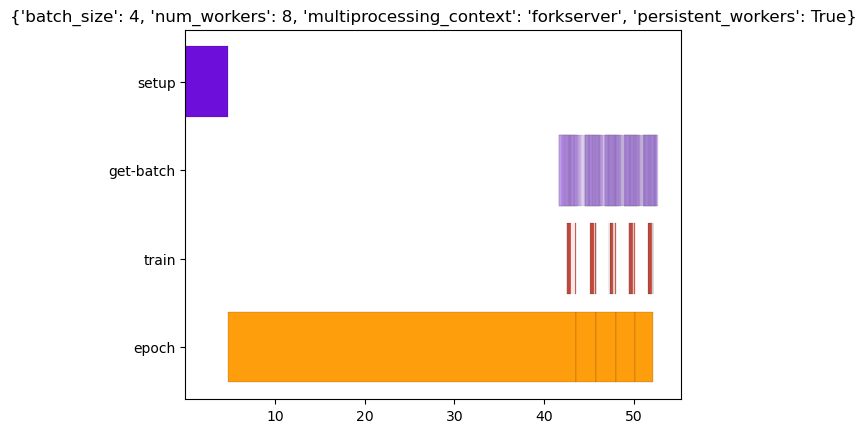

In [31]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 8 --persistent-workers > logs/with_8_workers.txt
plot_log("logs/with_8_workers.txt")

average batch duration 0.13740925583988428


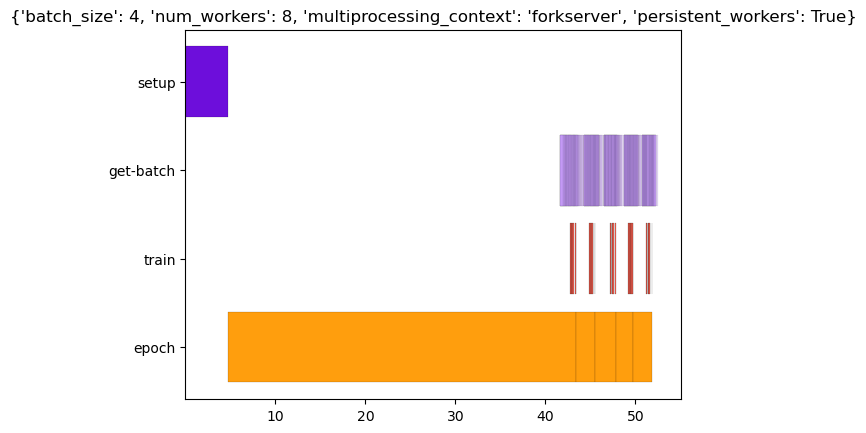

In [32]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 8 --persistent-workers --dask-threads 4 > logs/with_8_workers_4_threads.txt
plot_log("logs/with_8_workers_4_threads.txt")

average batch duration 0.13414244819432497


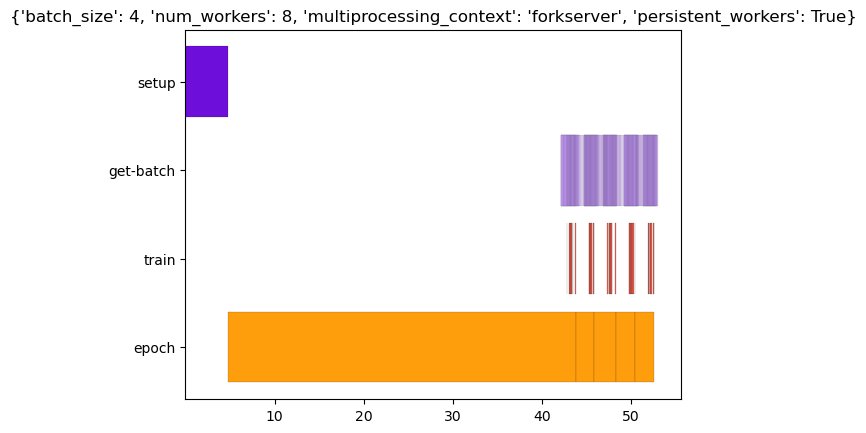

In [35]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 8 --persistent-workers --dask-threads 4 --dask-cache 1000000000 > logs/with_8_workers_4_threads_cache.txt
plot_log("logs/with_8_workers_4_threads_cache.txt")

average batch duration 0.36570489779114723


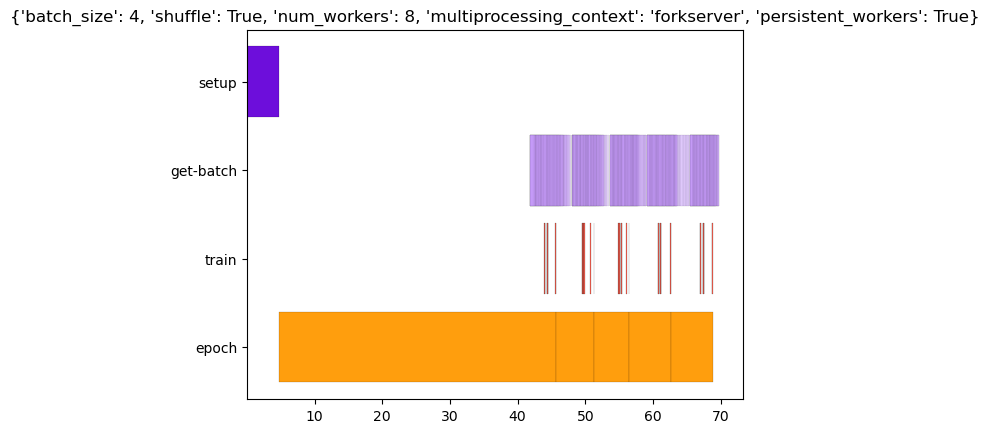

In [36]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 8 --persistent-workers --dask-threads 4 --dask-cache 1000000000 --shuffle > logs/with_8_workers_4_threads_cache_shuffle.txt
plot_log("logs/with_8_workers_4_threads_cache_shuffle.txt")

average batch duration 0.3207552609620271


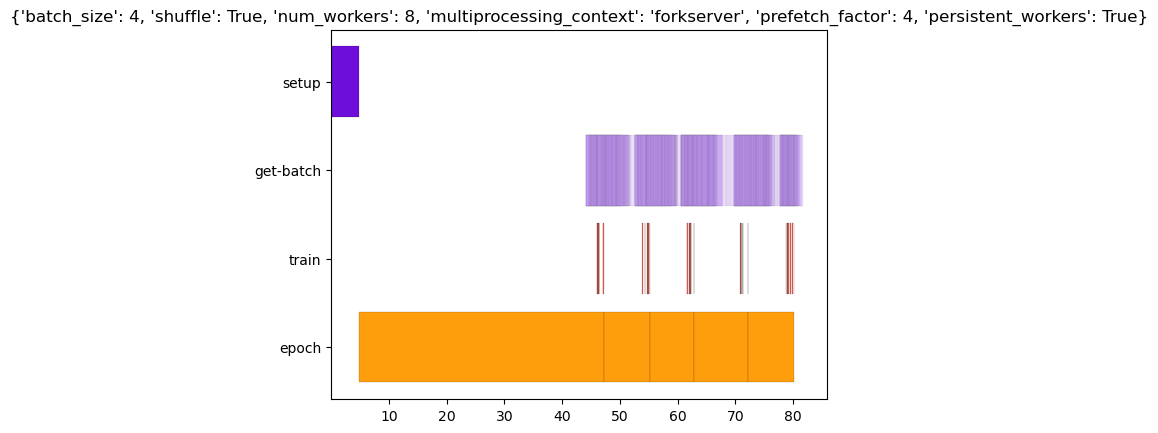

In [40]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 8 --persistent-workers --dask-threads 4 --dask-cache 1000000000 --shuffle --prefetch-factor 4 > logs/with_8_workers_4_threads_cache_shuffle_prefetch_4.txt
plot_log("logs/with_8_workers_4_threads_cache_shuffle_prefetch_4.txt")

average batch duration 0.3310670581128862


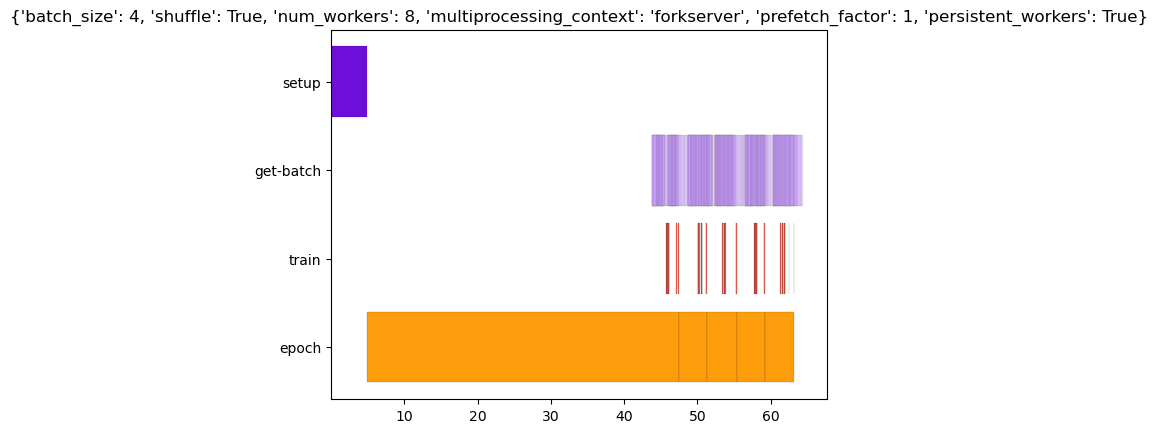

In [42]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 8 --persistent-workers --dask-threads 4 --dask-cache 1000000000 --shuffle --prefetch-factor 1 > logs/with_8_workers_4_threads_cache_shuffle_prefetch_1.txt
plot_log("logs/with_8_workers_4_threads_cache_shuffle_prefetch_1.txt")

In [ ]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 8 --persistent-workers --dask-threads 4 --dask-cache 1000000000 --shuffle --prefetch-factor 1 > logs/with_8_workers_4_threads_cache_shuffle_prefetch_1.txt
plot_log("logs/with_8_workers_4_threads_cache_shuffle_prefetch_1.txt")

average batch duration 0.311696814166175


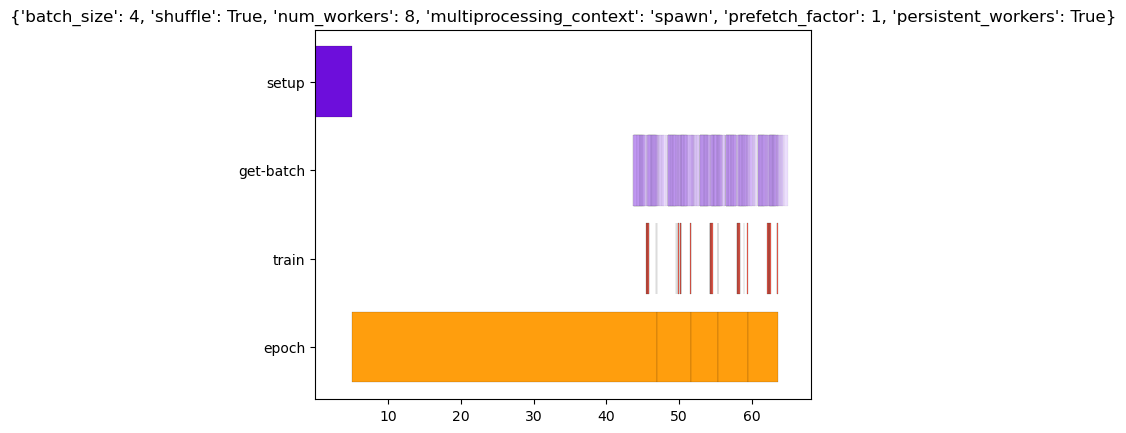

In [43]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 8 --persistent-workers --dask-threads 4 --dask-cache 1000000000 --shuffle --prefetch-factor 2 > logs/with_8_workers_4_threads_cache_shuffle_prefetch_1_spawn.txt
plot_log("logs/with_8_workers_4_threads_cache_shuffle_prefetch_1_spawn.txt")

In [ ]:
!python main.py --batch-size 4 --num-epochs 5 --num-batches 10 --num-workers 8 --persistent-workers --dask-threads 4 --dask-cache 1000000000 --shuffle --prefetch-factor 2 > logs/with_8_workers_4_threads_cache_shuffle_prefetch_1_spawn.txt
plot_log("logs/with_8_workers_4_threads_cache_shuffle_prefetch_2.txt")